<a href="https://colab.research.google.com/github/YasinnSoylu/actt/blob/main/optimizer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
! pip install kaggle

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
! mkdir ~/.kaggle


mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [3]:
! cp kaggle.json ~/.kaggle/


In [4]:
! chmod 600 ~/.kaggle/kaggle.json


In [5]:
!kaggle datasets download -d kmader/skin-cancer-mnist-ham10000

skin-cancer-mnist-ham10000.zip: Skipping, found more recently modified local copy (use --force to force download)


In [6]:
! unzip skin-cancer-mnist-ham10000.zip


Archive:  skin-cancer-mnist-ham10000.zip
replace HAM10000_images_part_1/ISIC_0024306.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [31]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
from glob import glob
import seaborn as sns
from PIL import Image
np.random.seed(123)
from sklearn.preprocessing import label_binarize
from sklearn.metrics import confusion_matrix
import itertools

import keras
from keras.utils.np_utils import to_categorical # used for converting labels to one-hot-encoding
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from keras import backend as K
import itertools
from tensorflow.keras.layers import BatchNormalization
from keras.utils.np_utils import to_categorical # convert to one-hot-encoding
from tensorflow.keras.callbacks import ModelCheckpoint

from keras.optimizers import Adam , RMSprop ,SGD ,Adadelta , Adagrad , Adamax , Ftrl , Nadam
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau
from sklearn.model_selection import train_test_split

In [2]:
image_path = {os.path.splitext(os.path.basename(x))[0]: x
                     for x in glob(os.path.join('/content/HAM10000/', '*', '*.jpg'))}

lesion_type_dict = {
    'nv': 'Melanocytic nevi',
    'mel': 'Melanoma',
    'bkl': 'Benign keratosis-like lesions ',
    'bcc': 'Basal cell carcinoma',
    'akiec': 'Actinic keratoses',
    'vasc': 'Vascular lesions',
    'df': 'Dermatofibroma'
}                     

In [3]:
skin_df = pd.read_csv(os.path.join( '/content/HAM10000/HAM10000_metadata.csv'))


In [4]:
skin_df['path'] = skin_df['image_id'].map(image_path.get)
skin_df['cell_type'] = skin_df['dx'].map(lesion_type_dict.get) 
skin_df['cell_type_idx'] = pd.Categorical(skin_df['cell_type']).codes

In [5]:
skin_df.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization,path,cell_type,cell_type_idx
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp,/content/HAM10000/ham10000_images_part_1/ISIC_...,Benign keratosis-like lesions,2
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp,/content/HAM10000/ham10000_images_part_1/ISIC_...,Benign keratosis-like lesions,2
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp,/content/HAM10000/ham10000_images_part_1/ISIC_...,Benign keratosis-like lesions,2
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp,/content/HAM10000/ham10000_images_part_1/ISIC_...,Benign keratosis-like lesions,2
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear,/content/HAM10000/ham10000_images_part_2/ISIC_...,Benign keratosis-like lesions,2


In [6]:
skin_df['path'] = skin_df['image_id'].map(image_path.get)
#Use the path to read images.
skin_df['image'] = skin_df['path'].map(lambda x: np.asarray(Image.open(x).resize((32,32))))

In [7]:
features=skin_df.drop(columns=['cell_type_idx'],axis=1)
target=skin_df['cell_type_idx']

In [8]:
x_train_o, x_test_o, y_train_o, y_test_o = train_test_split(features, target, test_size=0.20,random_state=42)

x_train = np.asarray(x_train_o['image'].tolist())
x_test = np.asarray(x_test_o['image'].tolist())

x_train_mean = np.mean(x_train)
x_train_std = np.std(x_train)

x_test_mean = np.mean(x_test)
x_test_std = np.std(x_test)

x_train = (x_train - x_train_mean)/x_train_std
x_test = (x_test - x_test_mean)/x_test_std

In [9]:
# Perform one-hot encoding on the labels
y_train = to_categorical(y_train_o, num_classes = 7)
y_test = to_categorical(y_test_o, num_classes = 7)

In [10]:
x_train, x_validate, y_train, y_validate = train_test_split(x_train, y_train, test_size = 0.1, random_state = 2)

In [11]:
# Reshape image in 3 dimensions (height = 128px, width = 128px , canal = 3)
x_train = x_train.reshape(x_train.shape[0], *(32, 32, 3))
x_test = x_test.reshape(x_test.shape[0], *(32, 32, 3))
x_validate = x_validate.reshape(x_validate.shape[0], *(32, 32, 3))

In [12]:
# With data augmentation to prevent overfitting 

datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.1, # Randomly zoom image 
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=False,  # randomly flip images
        vertical_flip=False)  # randomly flip images

datagen.fit(x_train)

# Fitting the model using Adam

In [13]:
from tensorflow.keras.layers import LeakyReLU, Dense
act = LeakyReLU()

In [14]:

input_shape = (32, 32, 3)
num_classes = 7

model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3),activation=act,padding = 'Same',input_shape=input_shape))
model.add(Conv2D(32,kernel_size=(3, 3), activation=act,padding = 'Same',))
model.add(MaxPool2D(pool_size = (2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), activation=act,padding = 'Same'))
model.add(Conv2D(64, (3, 3), activation=act,padding = 'Same'))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(0.40))

model.add(Flatten())
model.add(Dense(128, activation=act))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 32, 32, 32)        896       
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 32)        9248      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 16, 16, 32)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 16, 16, 32)        0         
                                                                 
 conv2d_2 (Conv2D)           (None, 16, 16, 64)        18496     
                                                                 
 conv2d_3 (Conv2D)           (None, 16, 16, 64)        36928     
                                                        

In [15]:
# Define the optimizer
optimizer = Adam()
# Compile the model
model.compile(optimizer = optimizer , loss = "categorical_crossentropy", metrics=["accuracy"])

In [19]:
reduce_lr = ReduceLROnPlateau(monitor='val_acc', factor=0.2,
                              patience=5,mode="max")


filepath="best_model_LeakyReLU.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')

In [20]:
# Fit the model
epochs = 10 
batch_size = 64
history_adam= model.fit_generator(datagen.flow(x_train,y_train, batch_size=batch_size),
                              epochs = epochs, validation_data = (x_validate,y_validate),
                              verbose = 1, steps_per_epoch=x_train.shape[0] // batch_size
                              , callbacks=[checkpoint,reduce_lr])

Epoch 1/10


<ipython-input-20-b9bb36fb1307>:4: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history_adam= model.fit_generator(datagen.flow(x_train,y_train, batch_size=batch_size),


112/112 [==============================] - ETA: 0s - loss: 0.8412 - accuracy: 0.6987

112/112 [==============================] - 48s 429ms/step - loss: 0.8412 - accuracy: 0.6987 - val_loss: 0.8692 - val_accuracy: 0.6908 - lr: 0.0010
Epoch 2/10
112/112 [==============================] - ETA: 0s - loss: 0.7895 - accuracy: 0.7218

112/112 [==============================] - 40s 361ms/step - loss: 0.7895 - accuracy: 0.7218 - val_loss: 0.8596 - val_accuracy: 0.6908 - lr: 0.0010
Epoch 3/10
112/112 [==============================] - ETA: 0s - loss: 0.7526 - accuracy: 0.7295

112/112 [==============================] - 44s 391ms/step - loss: 0.7526 - accuracy: 0.7295 - val_loss: 0.7934 - val_accuracy: 0.7107 - lr: 0.0010
Epoch 4/10
112/112 [==============================] - ETA: 0s - loss: 0.7381 - accuracy: 0.7371

112/112 [==============================] - 41s 363ms/step - loss: 0.7381 - accuracy: 0.7371 - val_loss: 0.7575 - val_accuracy: 0.7219 - lr: 0.0010
Epoch 5/10
112/112 [==============================] - ETA: 0s - loss: 0.7221 - accuracy: 0.7403

112/112 [==============================] - 41s 362ms/step - loss: 0.7221 - accuracy: 0.7403 - val_loss: 0.7948 - val_accuracy: 0.6820 - lr: 0.0010
Epoch 6/10
112/112 [==============================] - ETA: 0s - loss: 0.6908 - accuracy: 0.7526

112/112 [==============================] - 41s 363ms/step - loss: 0.6908 - accuracy: 0.7526 - val_loss: 0.8448 - val_accuracy: 0.6796 - lr: 0.0010
Epoch 7/10
112/112 [==============================] - ETA: 0s - loss: 0.6729 - accuracy: 0.7585

112/112 [==============================] - 42s 375ms/step - loss: 0.6729 - accuracy: 0.7585 - val_loss: 0.7589 - val_accuracy: 0.7107 - lr: 0.0010
Epoch 8/10
112/112 [==============================] - ETA: 0s - loss: 0.6645 - accuracy: 0.7573

112/112 [==============================] - 41s 365ms/step - loss: 0.6645 - accuracy: 0.7573 - val_loss: 0.7668 - val_accuracy: 0.7232 - lr: 0.0010
Epoch 9/10
112/112 [==============================] - ETA: 0s - loss: 0.6652 - accuracy: 0.7552

112/112 [==============================] - 41s 362ms/step - loss: 0.6652 - accuracy: 0.7552 - val_loss: 0.7712 - val_accuracy: 0.7195 - lr: 0.0010
Epoch 10/10
112/112 [==============================] - ETA: 0s - loss: 0.6407 - accuracy: 0.7635

112/112 [==============================] - 41s 363ms/step - loss: 0.6407 - accuracy: 0.7635 - val_loss: 0.7705 - val_accuracy: 0.7082 - lr: 0.0010


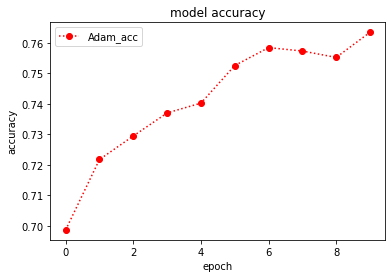

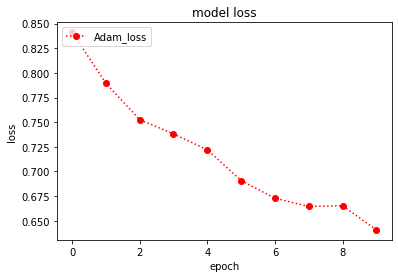

In [21]:
# summarize history for accuracy
plt.plot(history_adam.history['accuracy'] ,'o:r')
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['Adam_acc'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history_adam.history['loss'],'o:r')
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['Adam_loss', ], loc='upper left')
plt.show()

In [ ]:
asdasdasd

# Fitting the model using RMSprop

In [22]:
# Define the optimizer
optimizer = RMSprop()
# Compile the model
model.compile(optimizer = optimizer , loss = "categorical_crossentropy", metrics=["accuracy"])

In [23]:
# Fit the model
epochs = 10 
batch_size = 64
history_RMSprop= model.fit_generator(datagen.flow(x_train,y_train, batch_size=batch_size),
                              epochs = epochs, validation_data = (x_validate,y_validate),
                              verbose = 1, steps_per_epoch=x_train.shape[0] // batch_size
                              , callbacks=[checkpoint,reduce_lr])

Epoch 1/10


<ipython-input-23-36cbb2e9256f>:4: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history_RMSprop= model.fit_generator(datagen.flow(x_train,y_train, batch_size=batch_size),


112/112 [==============================] - ETA: 0s - loss: 0.6842 - accuracy: 0.7515

112/112 [==============================] - 42s 365ms/step - loss: 0.6842 - accuracy: 0.7515 - val_loss: 0.7853 - val_accuracy: 0.7007 - lr: 0.0010
Epoch 2/10
112/112 [==============================] - ETA: 0s - loss: 0.6670 - accuracy: 0.7620

112/112 [==============================] - 42s 377ms/step - loss: 0.6670 - accuracy: 0.7620 - val_loss: 0.8247 - val_accuracy: 0.7020 - lr: 0.0010
Epoch 3/10
112/112 [==============================] - ETA: 0s - loss: 0.6575 - accuracy: 0.7628

112/112 [==============================] - 41s 366ms/step - loss: 0.6575 - accuracy: 0.7628 - val_loss: 0.7736 - val_accuracy: 0.7145 - lr: 0.0010
Epoch 4/10
112/112 [==============================] - ETA: 0s - loss: 0.6564 - accuracy: 0.7618

112/112 [==============================] - 41s 364ms/step - loss: 0.6564 - accuracy: 0.7618 - val_loss: 0.7721 - val_accuracy: 0.7082 - lr: 0.0010
Epoch 5/10
112/112 [==============================] - ETA: 0s - loss: 0.6424 - accuracy: 0.7635

112/112 [==============================] - 41s 365ms/step - loss: 0.6424 - accuracy: 0.7635 - val_loss: 0.8555 - val_accuracy: 0.6596 - lr: 0.0010
Epoch 6/10
112/112 [==============================] - ETA: 0s - loss: 0.6447 - accuracy: 0.7607

112/112 [==============================] - 42s 377ms/step - loss: 0.6447 - accuracy: 0.7607 - val_loss: 0.7324 - val_accuracy: 0.7282 - lr: 0.0010
Epoch 7/10
112/112 [==============================] - ETA: 0s - loss: 0.6389 - accuracy: 0.7655

112/112 [==============================] - 41s 366ms/step - loss: 0.6389 - accuracy: 0.7655 - val_loss: 0.7387 - val_accuracy: 0.7132 - lr: 0.0010
Epoch 8/10
112/112 [==============================] - ETA: 0s - loss: 0.6288 - accuracy: 0.7713

112/112 [==============================] - 41s 366ms/step - loss: 0.6288 - accuracy: 0.7713 - val_loss: 0.7526 - val_accuracy: 0.7157 - lr: 0.0010
Epoch 9/10
112/112 [==============================] - ETA: 0s - loss: 0.6266 - accuracy: 0.7747

112/112 [==============================] - 43s 380ms/step - loss: 0.6266 - accuracy: 0.7747 - val_loss: 0.6977 - val_accuracy: 0.7382 - lr: 0.0010
Epoch 10/10
112/112 [==============================] - ETA: 0s - loss: 0.6319 - accuracy: 0.7716

112/112 [==============================] - 41s 364ms/step - loss: 0.6319 - accuracy: 0.7716 - val_loss: 0.7115 - val_accuracy: 0.7307 - lr: 0.0010


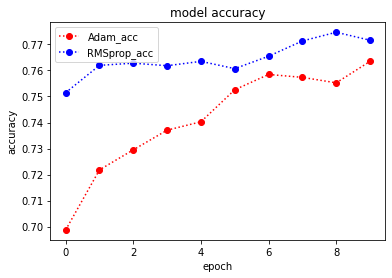

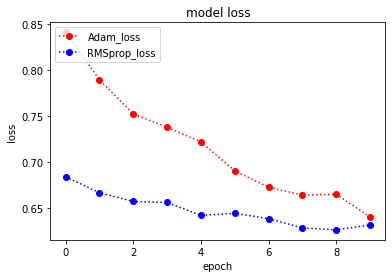

In [24]:
# summarize history for accuracy
plt.plot(history_adam.history['accuracy'] ,'o:r')
plt.plot(history_RMSprop.history['accuracy'] ,'o:b')

plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['Adam_acc',"RMSprop_acc"], loc='upper left')
plt.show()









# summarize history for loss
plt.plot(history_adam.history['loss'],'o:r')
plt.plot(history_RMSprop.history['loss'],'o:b')





plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['Adam_loss',"RMSprop_loss" ], loc='upper left')
plt.show()

# Fitting the model using SGD

In [25]:
# Define the optimizer
optimizer = SGD()
# Compile the model
model.compile(optimizer = optimizer , loss = "categorical_crossentropy", metrics=["accuracy"])



# Fit the model
epochs = 10 
batch_size = 64
history_SGD= model.fit_generator(datagen.flow(x_train,y_train, batch_size=batch_size),
                              epochs = epochs, validation_data = (x_validate,y_validate),
                              verbose = 1, steps_per_epoch=x_train.shape[0] // batch_size
                              , callbacks=[checkpoint,reduce_lr])

Epoch 1/10


<ipython-input-25-e37788689f57>:11: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history_SGD= model.fit_generator(datagen.flow(x_train,y_train, batch_size=batch_size),


112/112 [==============================] - ETA: 0s - loss: 0.5728 - accuracy: 0.7909

112/112 [==============================] - 42s 366ms/step - loss: 0.5728 - accuracy: 0.7909 - val_loss: 0.7155 - val_accuracy: 0.7232 - lr: 0.0100
Epoch 2/10
112/112 [==============================] - ETA: 0s - loss: 0.5700 - accuracy: 0.7907

112/112 [==============================] - 41s 364ms/step - loss: 0.5700 - accuracy: 0.7907 - val_loss: 0.7403 - val_accuracy: 0.7082 - lr: 0.0100
Epoch 3/10
112/112 [==============================] - ETA: 0s - loss: 0.5512 - accuracy: 0.8018

112/112 [==============================] - 42s 377ms/step - loss: 0.5512 - accuracy: 0.8018 - val_loss: 0.6914 - val_accuracy: 0.7344 - lr: 0.0100
Epoch 4/10
112/112 [==============================] - ETA: 0s - loss: 0.5556 - accuracy: 0.7976

112/112 [==============================] - 41s 369ms/step - loss: 0.5556 - accuracy: 0.7976 - val_loss: 0.6979 - val_accuracy: 0.7382 - lr: 0.0100
Epoch 5/10
112/112 [==============================] - ETA: 0s - loss: 0.5657 - accuracy: 0.7915

112/112 [==============================] - 41s 361ms/step - loss: 0.5657 - accuracy: 0.7915 - val_loss: 0.6876 - val_accuracy: 0.7344 - lr: 0.0100
Epoch 6/10
112/112 [==============================] - ETA: 0s - loss: 0.5503 - accuracy: 0.7939

112/112 [==============================] - 41s 365ms/step - loss: 0.5503 - accuracy: 0.7939 - val_loss: 0.6820 - val_accuracy: 0.7344 - lr: 0.0100
Epoch 7/10
112/112 [==============================] - ETA: 0s - loss: 0.5489 - accuracy: 0.7955

112/112 [==============================] - 42s 374ms/step - loss: 0.5489 - accuracy: 0.7955 - val_loss: 0.6815 - val_accuracy: 0.7419 - lr: 0.0100
Epoch 8/10
112/112 [==============================] - ETA: 0s - loss: 0.5576 - accuracy: 0.7933

112/112 [==============================] - 41s 364ms/step - loss: 0.5576 - accuracy: 0.7933 - val_loss: 0.6732 - val_accuracy: 0.7382 - lr: 0.0100
Epoch 9/10
112/112 [==============================] - ETA: 0s - loss: 0.5500 - accuracy: 0.8016

112/112 [==============================] - 41s 366ms/step - loss: 0.5500 - accuracy: 0.8016 - val_loss: 0.6970 - val_accuracy: 0.7419 - lr: 0.0100
Epoch 10/10
112/112 [==============================] - ETA: 0s - loss: 0.5464 - accuracy: 0.7989

112/112 [==============================] - 42s 376ms/step - loss: 0.5464 - accuracy: 0.7989 - val_loss: 0.7011 - val_accuracy: 0.7182 - lr: 0.0100


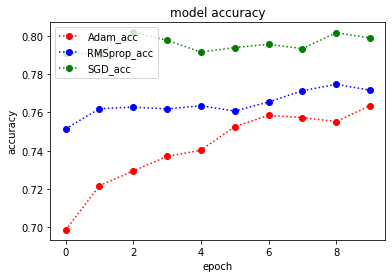

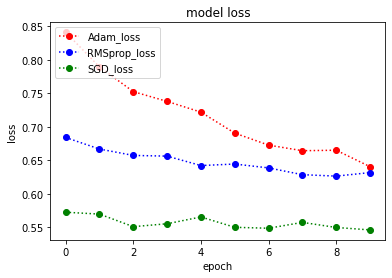

In [26]:
# summarize history for accuracy
plt.plot(history_adam.history['accuracy'] ,'o:r')
plt.plot(history_RMSprop.history['accuracy'] ,'o:b')
plt.plot(history_SGD.history['accuracy'] ,'o:g')

plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['Adam_acc',"RMSprop_acc","SGD_acc"], loc='upper left')
plt.show()









# summarize history for loss
plt.plot(history_adam.history['loss'],'o:r')
plt.plot(history_RMSprop.history['loss'],'o:b')
plt.plot(history_SGD.history['loss'],'o:g')





plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['Adam_loss',"RMSprop_loss" ,"SGD_loss"], loc='upper left')
plt.show()

In [ ]:
# Define the optimizer
optimizer = Adadelta()
# Compile the model
model.compile(optimizer = optimizer , loss = "categorical_crossentropy", metrics=["accuracy"])



# Fit the model
epochs = 10 
batch_size = 64
history_Adadelta= model.fit_generator(datagen.flow(x_train,y_train, batch_size=batch_size),
                              epochs = epochs, validation_data = (x_validate,y_validate),
                              verbose = 1, steps_per_epoch=x_train.shape[0] // batch_size
                              , callbacks=[checkpoint,reduce_lr])

In [28]:
# Define the optimizer
optimizer = Adagrad()
# Compile the model
model.compile(optimizer = optimizer , loss = "categorical_crossentropy", metrics=["accuracy"])



# Fit the model
epochs = 10 
batch_size = 64
history_Adagrad= model.fit_generator(datagen.flow(x_train,y_train, batch_size=batch_size),
                              epochs = epochs, validation_data = (x_validate,y_validate),
                              verbose = 1, steps_per_epoch=x_train.shape[0] // batch_size
                              , callbacks=[checkpoint,reduce_lr])

Epoch 1/10


<ipython-input-28-94087fd74b2e>:11: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history_Adagrad= model.fit_generator(datagen.flow(x_train,y_train, batch_size=batch_size),


112/112 [==============================] - ETA: 0s - loss: 0.5264 - accuracy: 0.8046

112/112 [==============================] - 42s 365ms/step - loss: 0.5264 - accuracy: 0.8046 - val_loss: 0.6797 - val_accuracy: 0.7282 - lr: 0.0010
Epoch 2/10
112/112 [==============================] - ETA: 0s - loss: 0.5271 - accuracy: 0.8045

112/112 [==============================] - 41s 365ms/step - loss: 0.5271 - accuracy: 0.8045 - val_loss: 0.6812 - val_accuracy: 0.7282 - lr: 0.0010
Epoch 3/10
112/112 [==============================] - ETA: 0s - loss: 0.5277 - accuracy: 0.8020

112/112 [==============================] - 41s 363ms/step - loss: 0.5277 - accuracy: 0.8020 - val_loss: 0.6770 - val_accuracy: 0.7282 - lr: 0.0010
Epoch 4/10
112/112 [==============================] - ETA: 0s - loss: 0.5311 - accuracy: 0.8025

112/112 [==============================] - 43s 388ms/step - loss: 0.5311 - accuracy: 0.8025 - val_loss: 0.6717 - val_accuracy: 0.7369 - lr: 0.0010
Epoch 5/10
112/112 [==============================] - ETA: 0s - loss: 0.5220 - accuracy: 0.8063

112/112 [==============================] - 41s 365ms/step - loss: 0.5220 - accuracy: 0.8063 - val_loss: 0.6731 - val_accuracy: 0.7344 - lr: 0.0010
Epoch 6/10
112/112 [==============================] - ETA: 0s - loss: 0.5242 - accuracy: 0.8051

112/112 [==============================] - 41s 364ms/step - loss: 0.5242 - accuracy: 0.8051 - val_loss: 0.6783 - val_accuracy: 0.7282 - lr: 0.0010
Epoch 7/10
112/112 [==============================] - ETA: 0s - loss: 0.5275 - accuracy: 0.8048

112/112 [==============================] - 41s 364ms/step - loss: 0.5275 - accuracy: 0.8048 - val_loss: 0.6737 - val_accuracy: 0.7282 - lr: 0.0010
Epoch 8/10
112/112 [==============================] - ETA: 0s - loss: 0.5282 - accuracy: 0.8034

112/112 [==============================] - 41s 363ms/step - loss: 0.5282 - accuracy: 0.8034 - val_loss: 0.6726 - val_accuracy: 0.7332 - lr: 0.0010
Epoch 9/10
112/112 [==============================] - ETA: 0s - loss: 0.5256 - accuracy: 0.8027

112/112 [==============================] - 42s 377ms/step - loss: 0.5256 - accuracy: 0.8027 - val_loss: 0.6740 - val_accuracy: 0.7307 - lr: 0.0010
Epoch 10/10
112/112 [==============================] - ETA: 0s - loss: 0.5187 - accuracy: 0.8025

112/112 [==============================] - 41s 363ms/step - loss: 0.5187 - accuracy: 0.8025 - val_loss: 0.6744 - val_accuracy: 0.7319 - lr: 0.0010


In [29]:
# Define the optimizer
optimizer = Adamax()
# Compile the model
model.compile(optimizer = optimizer , loss = "categorical_crossentropy", metrics=["accuracy"])



# Fit the model
epochs = 10 
batch_size = 64
history_Adamax= model.fit_generator(datagen.flow(x_train,y_train, batch_size=batch_size),
                              epochs = epochs, validation_data = (x_validate,y_validate),
                              verbose = 1, steps_per_epoch=x_train.shape[0] // batch_size
                              , callbacks=[checkpoint,reduce_lr])

Epoch 1/10


<ipython-input-29-7920ed01ae2d>:11: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history_Adamax= model.fit_generator(datagen.flow(x_train,y_train, batch_size=batch_size),


112/112 [==============================] - ETA: 0s - loss: 0.5490 - accuracy: 0.7988

112/112 [==============================] - 42s 364ms/step - loss: 0.5490 - accuracy: 0.7988 - val_loss: 0.6916 - val_accuracy: 0.7257 - lr: 0.0010
Epoch 2/10
112/112 [==============================] - ETA: 0s - loss: 0.5425 - accuracy: 0.7985

112/112 [==============================] - 41s 363ms/step - loss: 0.5425 - accuracy: 0.7985 - val_loss: 0.6854 - val_accuracy: 0.7244 - lr: 0.0010
Epoch 3/10
112/112 [==============================] - ETA: 0s - loss: 0.5306 - accuracy: 0.8046

112/112 [==============================] - 43s 383ms/step - loss: 0.5306 - accuracy: 0.8046 - val_loss: 0.6718 - val_accuracy: 0.7444 - lr: 0.0010
Epoch 4/10
112/112 [==============================] - ETA: 0s - loss: 0.5264 - accuracy: 0.8044

112/112 [==============================] - 44s 390ms/step - loss: 0.5264 - accuracy: 0.8044 - val_loss: 0.7017 - val_accuracy: 0.7282 - lr: 0.0010
Epoch 5/10
112/112 [==============================] - ETA: 0s - loss: 0.5338 - accuracy: 0.8027

112/112 [==============================] - 50s 443ms/step - loss: 0.5338 - accuracy: 0.8027 - val_loss: 0.6740 - val_accuracy: 0.7406 - lr: 0.0010
Epoch 6/10
112/112 [==============================] - ETA: 0s - loss: 0.5236 - accuracy: 0.8058

112/112 [==============================] - 47s 423ms/step - loss: 0.5236 - accuracy: 0.8058 - val_loss: 0.6651 - val_accuracy: 0.7481 - lr: 0.0010
Epoch 7/10
112/112 [==============================] - ETA: 0s - loss: 0.5183 - accuracy: 0.8059

112/112 [==============================] - 56s 496ms/step - loss: 0.5183 - accuracy: 0.8059 - val_loss: 0.6705 - val_accuracy: 0.7394 - lr: 0.0010
Epoch 8/10
112/112 [==============================] - ETA: 0s - loss: 0.5112 - accuracy: 0.8091

112/112 [==============================] - 44s 394ms/step - loss: 0.5112 - accuracy: 0.8091 - val_loss: 0.6548 - val_accuracy: 0.7519 - lr: 0.0010
Epoch 9/10
112/112 [==============================] - ETA: 0s - loss: 0.5129 - accuracy: 0.8097

112/112 [==============================] - 42s 372ms/step - loss: 0.5129 - accuracy: 0.8097 - val_loss: 0.6518 - val_accuracy: 0.7544 - lr: 0.0010
Epoch 10/10
112/112 [==============================] - ETA: 0s - loss: 0.5009 - accuracy: 0.8129

112/112 [==============================] - 42s 377ms/step - loss: 0.5009 - accuracy: 0.8129 - val_loss: 0.6678 - val_accuracy: 0.7394 - lr: 0.0010


In [32]:
# Define the optimizer
optimizer = Nadam()
# Compile the model
model.compile(optimizer = optimizer , loss = "categorical_crossentropy", metrics=["accuracy"])



# Fit the model
epochs = 10 
batch_size = 64
history_Nadam= model.fit_generator(datagen.flow(x_train,y_train, batch_size=batch_size),
                              epochs = epochs, validation_data = (x_validate,y_validate),
                              verbose = 1, steps_per_epoch=x_train.shape[0] // batch_size
                              , callbacks=[checkpoint,reduce_lr])

Epoch 1/10


<ipython-input-32-9405d50a304a>:11: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history_Nadam= model.fit_generator(datagen.flow(x_train,y_train, batch_size=batch_size),


112/112 [==============================] - ETA: 0s - loss: 0.5638 - accuracy: 0.7967

112/112 [==============================] - 45s 385ms/step - loss: 0.5638 - accuracy: 0.7967 - val_loss: 0.6939 - val_accuracy: 0.7431 - lr: 0.0010
Epoch 2/10
112/112 [==============================] - ETA: 0s - loss: 0.5653 - accuracy: 0.7883

112/112 [==============================] - 51s 459ms/step - loss: 0.5653 - accuracy: 0.7883 - val_loss: 0.7126 - val_accuracy: 0.7294 - lr: 0.0010
Epoch 3/10
112/112 [==============================] - ETA: 0s - loss: 0.5595 - accuracy: 0.7964

112/112 [==============================] - 42s 370ms/step - loss: 0.5595 - accuracy: 0.7964 - val_loss: 0.6797 - val_accuracy: 0.7406 - lr: 0.0010
Epoch 4/10
112/112 [==============================] - ETA: 0s - loss: 0.5520 - accuracy: 0.7996

112/112 [==============================] - 41s 369ms/step - loss: 0.5520 - accuracy: 0.7996 - val_loss: 0.6516 - val_accuracy: 0.7531 - lr: 0.0010
Epoch 5/10
112/112 [==============================] - ETA: 0s - loss: 0.5489 - accuracy: 0.7992

112/112 [==============================] - 44s 389ms/step - loss: 0.5489 - accuracy: 0.7992 - val_loss: 0.7170 - val_accuracy: 0.7157 - lr: 0.0010
Epoch 6/10
112/112 [==============================] - ETA: 0s - loss: 0.5410 - accuracy: 0.7996

112/112 [==============================] - 42s 371ms/step - loss: 0.5410 - accuracy: 0.7996 - val_loss: 0.7117 - val_accuracy: 0.7232 - lr: 0.0010
Epoch 7/10
112/112 [==============================] - ETA: 0s - loss: 0.5504 - accuracy: 0.7926

112/112 [==============================] - 41s 369ms/step - loss: 0.5504 - accuracy: 0.7926 - val_loss: 0.6880 - val_accuracy: 0.7406 - lr: 0.0010
Epoch 8/10
112/112 [==============================] - ETA: 0s - loss: 0.5425 - accuracy: 0.7964

112/112 [==============================] - 42s 373ms/step - loss: 0.5425 - accuracy: 0.7964 - val_loss: 0.6636 - val_accuracy: 0.7406 - lr: 0.0010
Epoch 9/10
112/112 [==============================] - ETA: 0s - loss: 0.5379 - accuracy: 0.7971

112/112 [==============================] - 42s 373ms/step - loss: 0.5379 - accuracy: 0.7971 - val_loss: 0.6895 - val_accuracy: 0.7456 - lr: 0.0010
Epoch 10/10
112/112 [==============================] - ETA: 0s - loss: 0.5396 - accuracy: 0.8004

112/112 [==============================] - 42s 371ms/step - loss: 0.5396 - accuracy: 0.8004 - val_loss: 0.6556 - val_accuracy: 0.7419 - lr: 0.0010


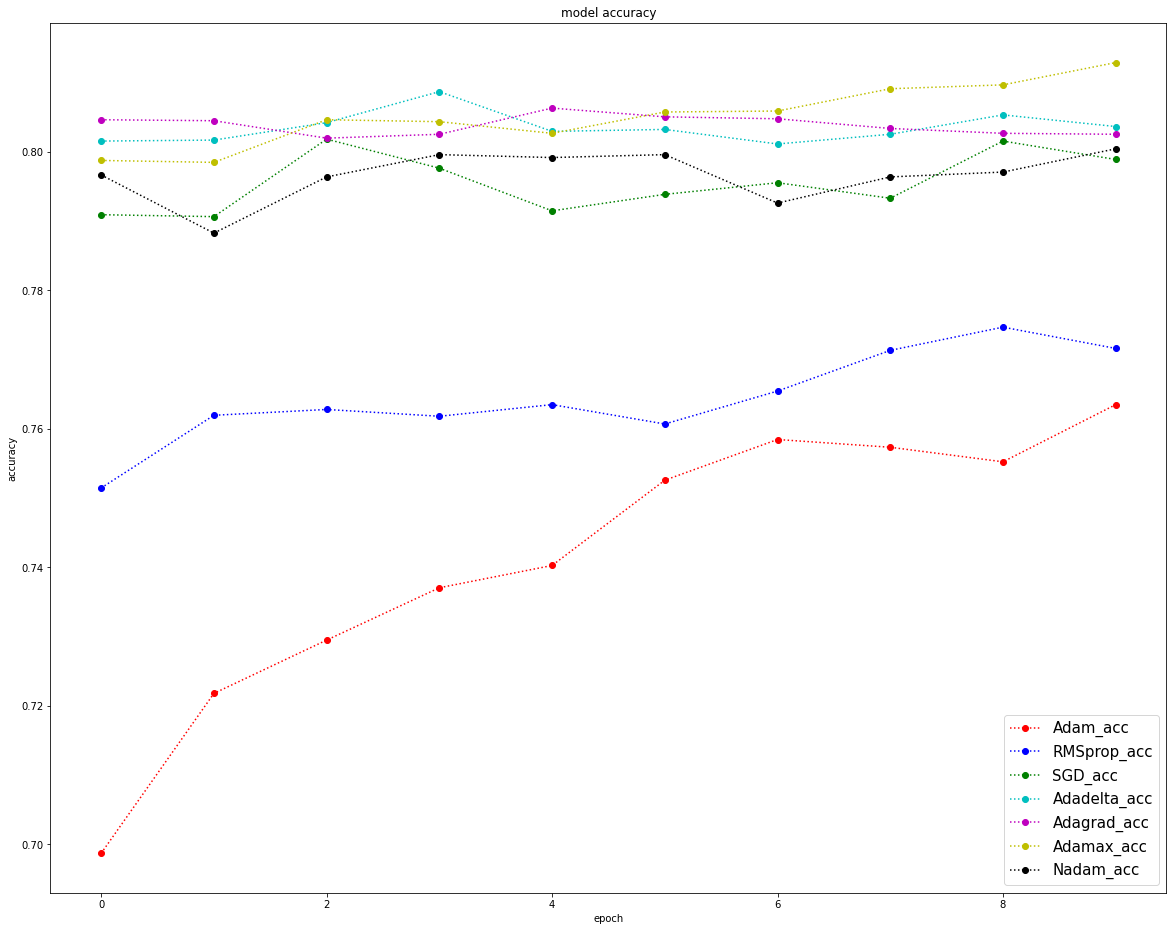

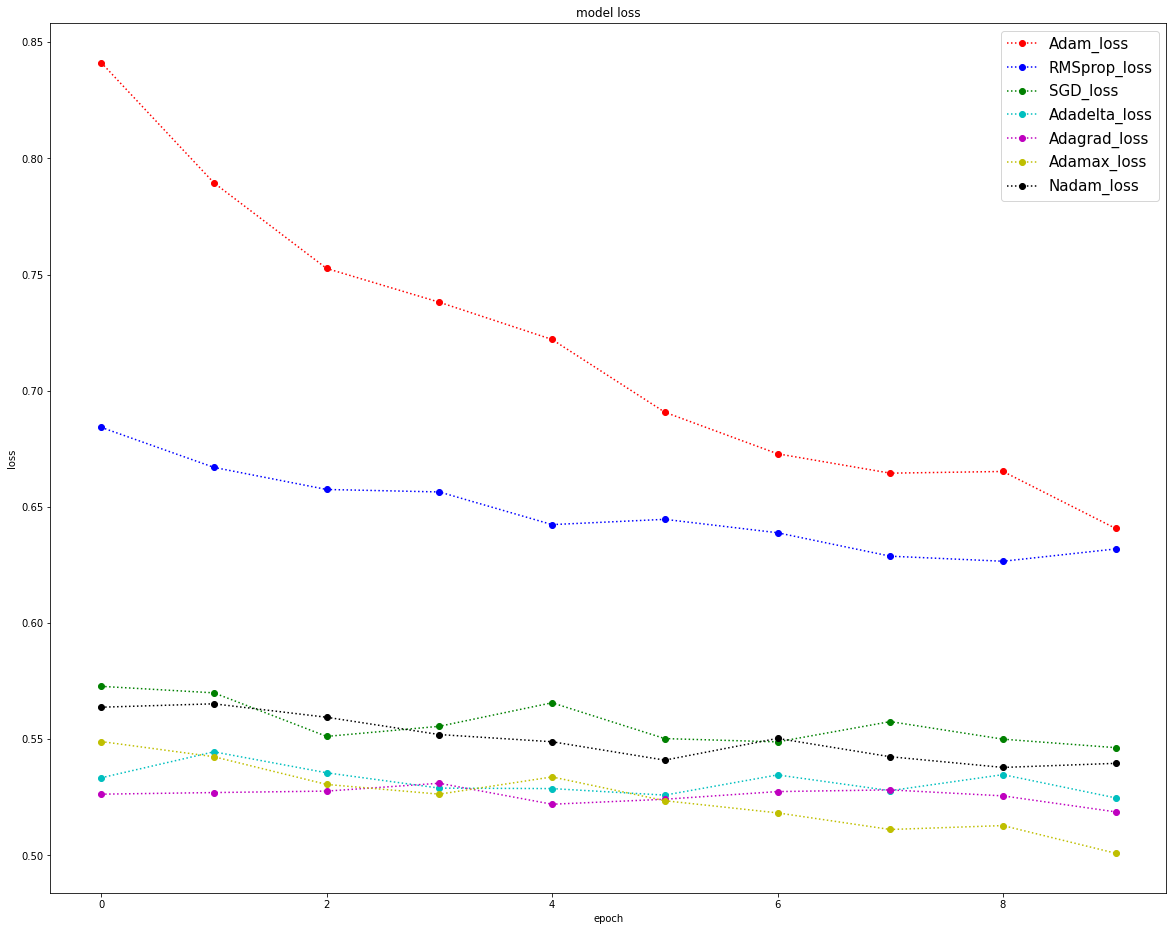

In [41]:
# summarize history for accuracy
plt.rcParams["figure.figsize"] = (20,16)
plt.plot(history_adam.history['accuracy'] ,'o:r')
plt.plot(history_RMSprop.history['accuracy'] ,'o:b')
plt.plot(history_SGD.history['accuracy'] ,'o:g')
plt.plot(history_Adadelta.history['accuracy'] ,'o:c')
plt.plot(history_Adagrad.history['accuracy'] ,'o:m')
plt.plot(history_Adamax.history['accuracy'] ,'o:y')
plt.plot(history_Nadam.history['accuracy'] ,'o:k')

#********************************************************
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['Adam_acc',"RMSprop_acc","SGD_acc","Adadelta_acc","Adagrad_acc","Adamax_acc","Nadam_acc"], loc='lower right',prop={'size': 15})
plt.show()

# summarize history for loss
plt.plot(history_adam.history['loss'] ,'o:r')
plt.plot(history_RMSprop.history['loss'] ,'o:b')
plt.plot(history_SGD.history['loss'] ,'o:g')
plt.plot(history_Adadelta.history['loss'] ,'o:c')
plt.plot(history_Adagrad.history['loss'] ,'o:m')
plt.plot(history_Adamax.history['loss'] ,'o:y')
plt.plot(history_Nadam.history['loss'] ,'o:k')
#********************************************************
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['Adam_loss',"RMSprop_loss" ,"SGD_loss","Adadelta_loss","Adagrad_loss","Adamax_loss","Nadam_loss"], loc='upper right',prop={'size': 15})
plt.show()